# messing_around_with_covariance_matrices
 - 

In [2]:
import time
import numpy as np
import scipy.stats as stats
import math
import random
from collections import defaultdict
import os
import sys
from collections import Counter
import glob 
import warnings
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import importlib
from astropy.time import Time

# -------------------------------------------------------------------------------------
# Local imports
# -------------------------------------------------------------------------------------
sys.path.append( os.path.join(os.path.dirname(os.getcwd() ), 'orbit_cheby')  )
import nbody_reader 
import orbit_cheby
importlib.reload(nbody_reader)
importlib.reload(orbit_cheby)


<module 'orbit_cheby' from '/Users/matthewjohnpayne/opt/anaconda3/lib/python3.7/site-packages/orbit_cheby/__init__.py'>

# ...

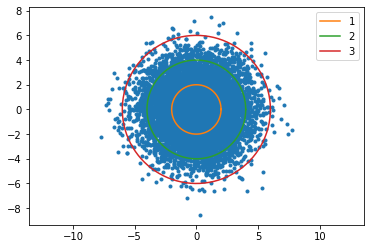

array([[ 4.0534315 , -0.04920601],
       [-0.04920601,  3.93852934]])

In [43]:
mean = [0, 0]
od=0
cov = [[4, od], [od, 4]]  # diagonal covariance
#https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.multivariate_normal.html
x, y = np.random.multivariate_normal(mean, cov, 10000).T

# plot data
plt.plot(x, y, '.')

# specify & plot ellipse 
u=mean[0]     #x-position of the center
v=mean[1]    #y-position of the center
a=cov[0][0]**0.5       #radius on the x-axis
b=cov[1][1]**0.5       #radius on the y-axis

t = np.linspace(0, 2*np.pi, 100)
for i in range(1,4):
    plt.plot( u+a*i*np.cos(t) , v+b*i*np.sin(t) , label=str(i))


plt.legend()
plt.axis('equal')
plt.show()

# estimate the CoV from the data 
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.cov.html
np.cov( np.array([x,y]))

[1, 0]

In [ ]:
#https://www.math.ubc.ca/~pwalls/math-python/differentiation/differentiation/
def derivative(f,a,method='central',h=0.01):
    '''Compute the difference formula for f'(a) with step size h.

    Parameters
    ----------
    f : function
        Vectorized function of one variable
    a : number
        Compute derivative at x = a
    method : string
        Difference formula: 'forward', 'backward' or 'central'
    h : number
        Step size in difference formula

    Returns
    -------
    float
        Difference formula:
            central: f(a+h) - f(a-h))/2h
            forward: f(a+h) - f(a))/h
            backward: f(a) - f(a-h))/h            
    '''
    return (f(a + h) - f(a - h))/(2*h)
    """
    if method == 'central':
        return (f(a + h) - f(a - h))/(2*h)
    elif method == 'forward':
        return (f(a + h) - f(a))/h
    elif method == 'backward':
        return (f(a) - f(a - h))/h
    else:
        raise ValueError("Method must be 'central', 'forward' or 'backward'.")
    """

In [44]:
# http://mpmath.org/doc/current/calculus/differentiation.html#

# scipy.misc.derivative for multiple argument function
 https://stackoverflow.com/questions/20708038/scipy-misc-derivative-for-multiple-argument-function

In [59]:
from scipy.misc import derivative


def foo(x, y):
  return(x**2 + y**3)


def partial_derivative(func, var=0, point=[]):
    args = point[:] ; print(args)
    def wraps(x):
        args[var] = x ; print('wa',args, point[var])
        return func(*args)
    return derivative(wraps, point[var], dx = 1e-6)


In [60]:
derivative(foo, 1, dx = 1e-6, args = (3, ))


2.000000000279556

In [61]:
partial_derivative(foo, 0, [3,1])

[3, 1]
wa [2.999999, 1] 3
wa [3.0, 1] 3
wa [3.000001, 1] 3


6.000000000838668

In [62]:
partial_derivative(foo, 1, [3,1])

[3, 1]
wa [3, 0.999999] 1
wa [3, 1.0] 1
wa [3, 1.000001] 1


2.9999999995311555

# Num Diff Tools
https://numdifftools.readthedocs.io/en/latest/tutorials/getting_started.html#the-derivative

In [64]:
import numdifftools as nd

In [68]:
def foo2(x):
  return(x[0]**2 + x[1]**3)
jac = nd.Jacobian(foo2)([3,1])
jac

array([[6., 3.]])

In [76]:
def RADEC(s):
    # s is a vector with >= 3 components (i.e. X,Y,Z)
    # This returns a two component vector, i.e. return[0] ~ RA, return[1] ~ Dec 
    return np.array( [s[0]**2 + s[1]**3 + s[2]**4, np.cos(s[0] - s[1])*s[0]*s[1]] )
X = np.array([3,1,2]) ; print(X)
R = RADEC(X) ; print(R)
jac = nd.Jacobian(RADEC)(X)
jac, jac.T

[3 1 2]
[26.         -1.24844051]


(array([[ 6.        ,  3.        , 32.        ],
        [-3.14403912,  1.47945177,  0.        ]]),
 array([[ 6.        , -3.14403912],
        [ 3.        ,  1.47945177],
        [32.        ,  0.        ]]))

# CoV Matrix for RA,Dec
- https://iopscience.iop.org/article/10.1086/316868/pdf

$\Sigma_{\bf\theta} = \left[\frac{d\theta({\bf\alpha},t)}{d{\bf\alpha}}\right]^T  \Sigma_{\bf\alpha}  \left[\frac{d\theta({\bf\alpha},t)}{d{\bf\alpha}}\right]$ 

$\Sigma_{(R,D)} = \left[\frac{d(R,D)({(X,Y,Z)},t)}{d{(X,Y,Z)}}\right]^T  \Sigma_{(X,Y,Z)}  \left[\frac{d(R,D)({(X,Y,Z)},t)}{d{(X,Y,Z)}}\right]$ 


-------


d UV = dUV / dX . dX/dt + dUV / dY . dY/dt + dUV / dZ . dZ/dt


In [87]:
# Set up fake CoV matrix for 3 coords, XYZ
od = 0.1 
COVxyz = np.array( [[1, od, od], [od,1,od], [od, od, 1]] ) ; print(COVxyz)

# Use the above jac calc ... 
XYZ = np.array([3,1,2]) ; print('XYZ:', XYZ) ; print('RADEC: ',RADEC(XYZ))
jac = nd.Jacobian(RADEC)(XYZ)
print('jac:',jac)
print('jac.T:',jac.T)
print('COVxyz . jac.T ',np.matmul(COVxyz, jac.T))
print('jac  . COVxyz ',np.matmul(jac , COVxyz, jac))

print()

print('jac . [COVxyz . jac.T ]',np.matmul(jac , np.matmul(COVxyz, jac.T)) )
print('[jac  . COVxyz] .jac.T', np.matmul(np.matmul(jac , COVxyz),jac.T))

print(' multidot:', np.linalg.multi_dot([jac , COVxyz, jac.T]))

[[1.  0.1 0.1]
 [0.1 1.  0.1]
 [0.1 0.1 1. ]]
XYZ: [3 1 2]
RADEC:  [26.         -1.24844051]
jac: [[ 6.          3.         32.        ]
 [-3.14403912  1.47945177  0.        ]]
jac.T: [[ 6.         -3.14403912]
 [ 3.          1.47945177]
 [32.          0.        ]]
COVxyz . jac.T  [[ 9.5        -2.99609394]
 [ 6.8         1.16504786]
 [32.9        -0.16645873]]
jac  . COVxyz  [[ 9.5         6.8        32.9       ]
 [-2.99609394  1.16504786 -0.16645873]]

jac . [COVxyz . jac.T ] [[1339.074       -33.24307711]
 [ -33.24307711    9.72446408]]
[jac  . COVxyz] .jac.T [[1339.074       -33.24307711]
 [ -33.24307711    9.72446408]]
 multidot: [[1339.074       -33.24307711]
 [ -33.24307711    9.72446408]]


In [1]:
with open('temp_data.txt' , 'r') as fh:
    data = fh.readlines() 

In [9]:
a = [ float(_.strip().split(",")[0]) for _ in data if '#' not in _ and len(_) > 4 ]
b = [ float(_.strip().split(",")[1]) for _ in data if '#' not in _ and len(_) > 4 ]
c = [ float(_.strip().split(",")[2]) for _ in data if '#' not in _ and len(_) > 4 ]
a, b, c

([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0],
 [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0],
 [3.0, 9.0, 27.0, 81.0, 64.0, 16.0, 4.0, 1.0])

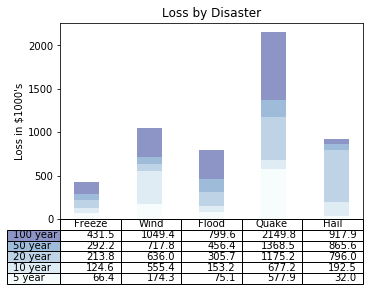

In [11]:
import matplotlib.pyplot as plt
import numpy as np 

data = [[ 66386, 174296,  75131, 577908,  32015],
        [ 58230, 381139,  78045,  99308, 160454],
        [ 89135,  80552, 152558, 497981, 603535],
        [ 78415,  81858, 150656, 193263,  69638],
        [139361, 331509, 343164, 781380,  52269]]

columns = ('Freeze', 'Wind', 'Flood', 'Quake', 'Hail')
rows = ['%d year' % x for x in (100, 50, 20, 10, 5)]

values = np.arange(0, 2500, 500)
value_increment = 1000

# Get some pastel shades for the colors
colors = plt.cm.BuPu(np.linspace(0, 0.5, len(rows)))
n_rows = len(data)

index = np.arange(len(columns)) + 0.3
bar_width = 0.4

# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.zeros(len(columns))

# Plot bars and create text labels for the table
cell_text = []
for row in range(n_rows):
    plt.bar(index, data[row], bar_width, bottom=y_offset, color=colors[row])
    y_offset = y_offset + data[row]
    cell_text.append(['%1.1f' % (x / 1000.0) for x in y_offset])
# Reverse colors and text labels to display the last value at the top.
colors = colors[::-1]
cell_text.reverse()

# Add a table at the bottom of the axes
the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      colLabels=columns,
                      loc='bottom')

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.2, bottom=0.2)

plt.ylabel("Loss in ${0}'s".format(value_increment))
plt.yticks(values * value_increment, ['%d' % val for val in values])
plt.xticks([])
plt.title('Loss by Disaster')

plt.show()

([<matplotlib.axis.XTick at 0x11f4f8250>,
 <a list of 15 Text xticklabel objects>)

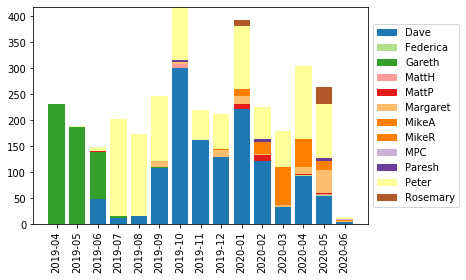

In [48]:
import matplotlib.pyplot as plt
import numpy as np 

# Raw Data 
data = """Month    Total     Dave Federica   Gareth    MattH    MattP Margaret    MikeA    MikeR      MPC   Paresh    Peter Rosemary
2019-04    231        0        0      231        0        0        0        0        0        0        0        0        0
2019-05    188        0        0      187        0        0        0        0        0        0        0        1        0
2019-06    149       48        0       90        1        1        0        0        0        0        0        9        0
2019-07    202       11        0        4        0        0        0        0        0        0        0      187        0
2019-08    173       16        0        0        0        0        0        0        0        0        0      157        0
2019-09    247      108        0        1        0        0       13        0        0        0        0      125        0
2019-10    418      300        0        0        8        0        3        0        1        0        3      103        0
2019-11    220      161        0        0        0        0        0        0        1        0        0       58        0
2019-12    212      129        0        0        0        0       13        0        2        0        0       68        0
2020-01    392      221        0        0        0       10       16       10        2        0        0      121       12
2020-02    225      121        0        0        0       12        2       23        0        0        6       61        0
2020-03    179       33        0        0        0        0        4       71        1        0        0       70        0
2020-04    304       93        2        0        0        1       13       43       11        0        1      140        0
2020-05    264       53        2        0        2        2       44        7       12        0        5      103       34
2020-06     13        3        0        0        0        0        3        0        2        1        0        4        0
"""

# Populate Data dictionary 
d = { k:[] for k in data.split('\n')[0].split() }
lines = data.split('\n')[1:]
for line in lines:
    for k,v in zip(keys, line.split() ) : 
        try:
            d[k].append( float(v))
        except:
            d[k].append(v)
            

# This just makes positions for the months 
index = range(1,len(d['Month'])+1,1)
# Set colormap
colors = plt.cm.Paired(np.linspace(0, 0.95, len(d)))
# We'll want to offset the numbers iteratively
offset = np.zeros( len(index) )
# Loop over each person
for n,k in enumerate(d.keys()):
    if k not in ['Month','Total']:
        # Make a plot (offset vertically)
        plt.bar(index, d[k], label=k, bottom=offset , color=colors[n])#, bar_width, bottom=y_offset, color=colors[row])
        # Increment the offset ready for the next round
        offset += np.array(d[k])
# Make legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Put "Month" labels onto the x-axis
plt.xticks(index, d['Month'], rotation=90 )
    #ax1.bar(range(1, 5), [6] * 4, bottom=range(1, 5),color='blue', edgecolor='black', hatch='//')